In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import logging
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
import gdown

In [2]:
def create_logger(log_file='training.log'):
    # Create a logger
    logger = logging.getLogger('my_logger')
    logger.setLevel(logging.INFO)  # Set the logging level

    # Create a file handler to log to a file
    if not os.path.exists('logs'):  # Create a logs directory if it doesn't exist
        os.makedirs('logs')
    file_handler = logging.FileHandler(os.path.join('logs', log_file))
    file_handler.setLevel(logging.INFO)

    # Create a console handler to log to console
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)

    # Create a logging format
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)

    # Add handlers to the logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    return logger

In [3]:
def get_loaders(batch_size, test_batch_size=256):
  logger = create_logger()

  logger.info("Starting to load the datasets...")
  transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

  full_training_data = torchvision.datasets.MNIST('./data', train = True, transform=transform, download = True)
  logger.info("Loaded full training data.")

  test_data = torchvision.datasets.MNIST('./data',train = False, transform=transform, download = True)
  logger.info("Loaded test data.")

  n_examples = len(full_training_data)
  n_train = int(n_examples * 0.5 + 1)
  n_valid = n_examples - n_train
  assert n_train > 1
  assert n_valid > 1

  training_data , validation_data = torch.utils.data.random_split ( full_training_data ,[n_train,n_valid])
  logger.info(f"Split the data into {len(training_data)} training examples and {len(validation_data)} validation examples.")

  train_loader = torch.utils.data.DataLoader(training_data,batch_size,shuffle = True)
  logger.info(f"Created training data loader with batch size {batch_size}.")

  validation_loader = torch.utils.data.DataLoader(validation_data,test_batch_size,shuffle = False)
  logger.info(f"Created validation data loader with batch size {test_batch_size}.")

  test_loader = torch.utils.data.DataLoader(test_data,test_batch_size,shuffle = False)
  logger.info(f"Created test data loader with batch size {test_batch_size}.")

  return train_loader,validation_loader,test_loader,logger

In [15]:
# Let's test our code!
train_loader, validation_loader, test_loader, logger = get_loaders(32)  # Capture all 4 values, including logger
for t in train_loader:
    print(type(t))  # Should print the type of the batch
    print(len(t))   # Should print the number of elements in the batch (usually 2: images and labels)
    print(type(t[0]))  # Should print the type of the images (should be a Tensor)
    print(t[0].size())  # Should print the size of the images (e.g., [batch_size, channels, height, width])
    break  # Only process the first batch for testing

2024-09-30 11:07:11,080 - INFO - Starting to load the datasets...
2024-09-30 11:07:11,080 - INFO - Starting to load the datasets...
2024-09-30 11:07:11,080 - INFO - Starting to load the datasets...
INFO:my_logger:Starting to load the datasets...
2024-09-30 11:07:11,396 - INFO - Loaded full training data.
2024-09-30 11:07:11,396 - INFO - Loaded full training data.
2024-09-30 11:07:11,396 - INFO - Loaded full training data.
INFO:my_logger:Loaded full training data.
2024-09-30 11:07:11,460 - INFO - Loaded test data.
2024-09-30 11:07:11,460 - INFO - Loaded test data.
2024-09-30 11:07:11,460 - INFO - Loaded test data.
INFO:my_logger:Loaded test data.
2024-09-30 11:07:11,485 - INFO - Split the data into 30001 training examples and 29999 validation examples.
2024-09-30 11:07:11,485 - INFO - Split the data into 30001 training examples and 29999 validation examples.
2024-09-30 11:07:11,485 - INFO - Split the data into 30001 training examples and 29999 validation examples.
INFO:my_logger:Split t

<class 'list'>
2
<class 'torch.Tensor'>
torch.Size([32, 1, 28, 28])


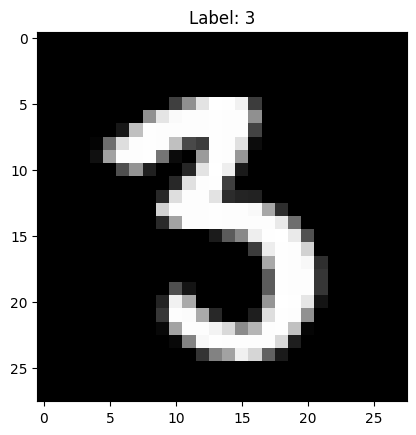

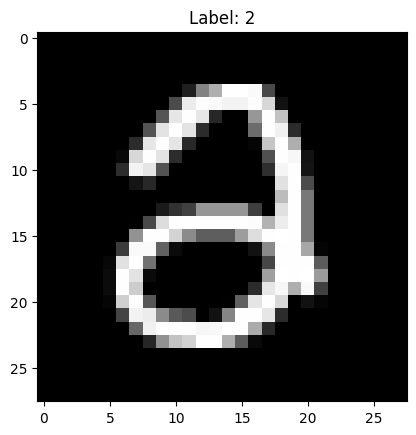

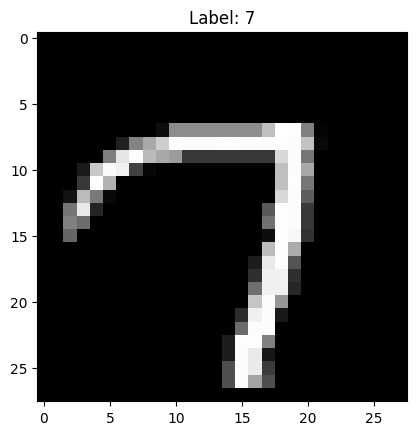

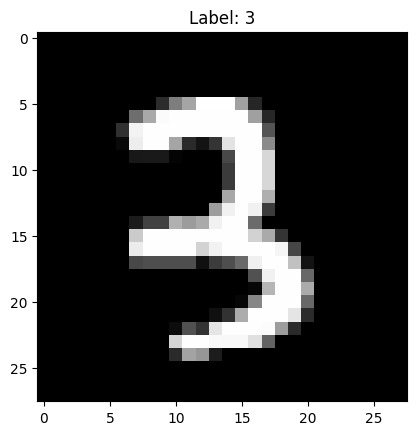

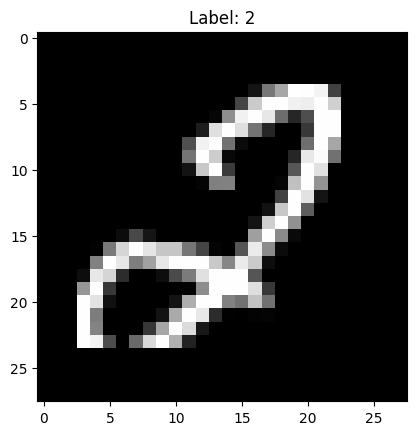

In [107]:
data_iter = iter(train_loader)
images, labels = next(data_iter)  # Get a batch of 32 images (based on batch_size=32)

# Display just a few images, let's say 5
for i in range(5):
    plt.imshow(images[i].squeeze(), cmap='gray')  # Remove the color channel (1x28x28 -> 28x28)
    plt.title(f"Label: {labels[i].item()}")  # Display the label
    plt.show()  # Show one image at a time

In [5]:
class MyFirstNetwork(torch.nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim):
    super(MyFirstNetwork,self).__init__()
    #first linear layer (input) to hidden layer
    self.fc1 = torch.nn.Linear(input_dim,hidden_dim)
    #Activation Function
    self.relu = torch.nn.ReLU()
    #Second linear layer to output
    self.fc2 = torch.nn.Linear(hidden_dim,output_dim)
    # PyTorch automatically initializes biases in Linear layers,
  def forward(self,x):
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

In [6]:
def get_optimizer(net,lr=0.01,wd=0,momentum=0):
  optimizer =torch.optim.SGD(
    net.parameters(),
    lr=lr,
    weight_decay = wd,
    momentum = momentum
  )
  return optimizer

In [7]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

In [8]:
def training_step(net, data_loader, optimizer, cost_function, device='cpu'):

    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.

    # Set the network to training mode
    net.train()

    # Iterate over the training set
    for batch_idx, (inputs, targets) in enumerate(data_loader):

        # Load data into GPU (if available)
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = net(inputs)

        # Loss computation
        loss = cost_function(outputs, targets)

        # Backward pass
        loss.backward()

        # Parameters update
        optimizer.step()

        # Gradients reset (this is important to avoid accumulation of gradients from previous batches)
        optimizer.zero_grad()

        # Fetch prediction and loss value
        samples += inputs.shape[0]
        cumulative_loss += loss.item()
        _, predicted = outputs.max(dim=1)  # max() returns (maximum_value, index_of_maximum_value)

        # Compute training accuracy
        cumulative_accuracy += predicted.eq(targets).sum().item()

    # Return average loss and accuracy for this epoch
    return cumulative_loss/samples, cumulative_accuracy/samples * 100
def test_step(net, data_loader, cost_function, device='cpu'):

    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.

    # Set the network to evaluation mode
    net.eval()

    # Disable gradient computation (since we are only testing)
    with torch.no_grad():

        # Iterate over the test set
        for batch_idx, (inputs, targets) in enumerate(data_loader):

            # Load data into GPU (if available)
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = net(inputs)

            # Loss computation
            loss = cost_function(outputs, targets)

            # Fetch prediction and loss value
            samples += inputs.shape[0]
            cumulative_loss += loss.item()
            _, predicted = outputs.max(dim=1)

            # Compute accuracy
            cumulative_accuracy += predicted.eq(targets).sum().item()

    # Return average loss and accuracy for this epoch
    return cumulative_loss/samples, cumulative_accuracy/samples * 100


In [9]:
# tensorboard logging utilities
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

# main function
def main(
      batch_size=128,
      input_dim=28*28,
      hidden_dim=100,
      output_dim=10,
      device='cpu:0',
      learning_rate=0.01,
      weight_decay=0.000001,
      momentum=0.9,
      epochs=10
    ):

  from torch.utils.tensorboard import SummaryWriter

  # Create a logger for the experiment
  writer = SummaryWriter(log_dir="runs/exp1")

  # Get dataloaders (assuming `get_data` returns train, val, test DataLoaders)
  train_loader, validation_loader, test_loader,logger = get_loaders(batch_size)

  # Instantiate the network and move it to the chosen device (GPU/CPU)
  net = MyFirstNetwork(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)

  # Instantiate the optimizer
  optimizer = get_optimizer(net, lr=learning_rate, wd=weight_decay, momentum=momentum)

  # Define the cost function
  cost_function = get_cost_function()

  # Compute evaluation results before training
  print('Before training:')
  train_loss, train_accuracy = test_step(net, train_loader, cost_function, device)
  val_loss, val_accuracy = test_step(net, validation_loader, cost_function, device)
  test_loss, test_accuracy = test_step(net, test_loader, cost_function, device)

  # Log to TensorBoard
  log_values(writer, -1, train_loss, train_accuracy, "Train")
  log_values(writer, -1, val_loss, val_accuracy, "Validation")
  log_values(writer, -1, test_loss, test_accuracy, "Test")

  print(f'\t Training loss {train_loss:.5f}, Training accuracy {train_accuracy:.2f}')
  print(f'\t Validation loss {val_loss:.5f}, Validation accuracy {val_accuracy:.2f}')
  print(f'\t Test loss {test_loss:.5f}, Test accuracy {test_accuracy:.2f}')
  print('-----------------------------------------------------')

  # For each epoch, train the network and then compute evaluation results
  for e in range(epochs):

    # Perform training step
    train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function, device)

    # Perform evaluation step
    val_loss, val_accuracy = test_step(net, validation_loader, cost_function, device)

    # Logs to TensorBoard
    log_values(writer, e, train_loss, train_accuracy, "Train")
    log_values(writer, e, val_loss, val_accuracy, "Validation")

    print(f'Epoch: {e+1}')
    print(f'\t Training loss {train_loss:.5f}, Training accuracy {train_accuracy:.2f}')
    print(f'\t Validation loss {val_loss:.5f}, Validation accuracy {val_accuracy:.2f}')
    print('-----------------------------------------------------')

  # Save the trained model
  model_path = 'mnist_model.pth'
  torch.save(net.state_dict(), model_path)
  print(f"Model saved to {model_path}")

  # Compute final evaluation results after training
  print('After training:')
  train_loss, train_accuracy = test_step(net, train_loader, cost_function, device)
  val_loss, val_accuracy = test_step(net, validation_loader, cost_function, device)
  test_loss, test_accuracy = test_step(net, test_loader, cost_function, device)

  # Log final results to TensorBoard
  log_values(writer, epochs, train_loss, train_accuracy, "Train")
  log_values(writer, epochs, val_loss, val_accuracy, "Validation")
  log_values(writer, epochs, test_loss, test_accuracy, "Test")

  print(f'\t Training loss {train_loss:.5f}, Training accuracy {train_accuracy:.2f}')
  print(f'\t Validation loss {val_loss:.5f}, Validation accuracy {val_accuracy:.2f}')
  print(f'\t Test loss {test_loss:.5f}, Test accuracy {test_accuracy:.2f}')
  print('-----------------------------------------------------')

  # Close the TensorBoard writer
  writer.close()


In [10]:
if __name__ == "__main__":
    main()

2024-09-30 10:03:58,491 - INFO - Starting to load the datasets...
2024-09-30 10:03:58,491 - INFO - Starting to load the datasets...
INFO:my_logger:Starting to load the datasets...
2024-09-30 10:03:58,615 - INFO - Loaded full training data.
2024-09-30 10:03:58,615 - INFO - Loaded full training data.
INFO:my_logger:Loaded full training data.
2024-09-30 10:03:58,640 - INFO - Loaded test data.
2024-09-30 10:03:58,640 - INFO - Loaded test data.
INFO:my_logger:Loaded test data.
2024-09-30 10:03:58,653 - INFO - Split the data into 30001 training examples and 29999 validation examples.
2024-09-30 10:03:58,653 - INFO - Split the data into 30001 training examples and 29999 validation examples.
INFO:my_logger:Split the data into 30001 training examples and 29999 validation examples.
2024-09-30 10:03:58,659 - INFO - Created training data loader with batch size 128.
2024-09-30 10:03:58,659 - INFO - Created training data loader with batch size 128.
INFO:my_logger:Created training data loader with ba

Before training:
	 Training loss 0.01809, Training accuracy 8.85
	 Validation loss 0.00908, Validation accuracy 9.18
	 Test loss 0.00924, Test accuracy 8.97
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00694, Training accuracy 78.04
	 Validation loss 0.00161, Validation accuracy 88.67
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00277, Training accuracy 89.85
	 Validation loss 0.00131, Validation accuracy 90.60
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00235, Training accuracy 91.22
	 Validation loss 0.00119, Validation accuracy 91.43
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00210, Training accuracy 92.23
	 Validation loss 0.00108, Validation accuracy 92.27
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00190, Training accuracy 93.06
	 Validation loss 0.00100, Validation accuracy 92.83
------------------